# Estimation de l'âge d'une personne
Deux concepts visant à optimiser un modèle de Deep learning :
-	Générateurs d’image, pour augmenter et varier un jeu de données
-	Les callbacks


## Chargement des données et preprocessing

In [1]:
import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D,Dropout, Flatten, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder # one-hot encoding for age
from keras.utils import to_categorical

from PIL import Image 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

image_path = 'face_age/'


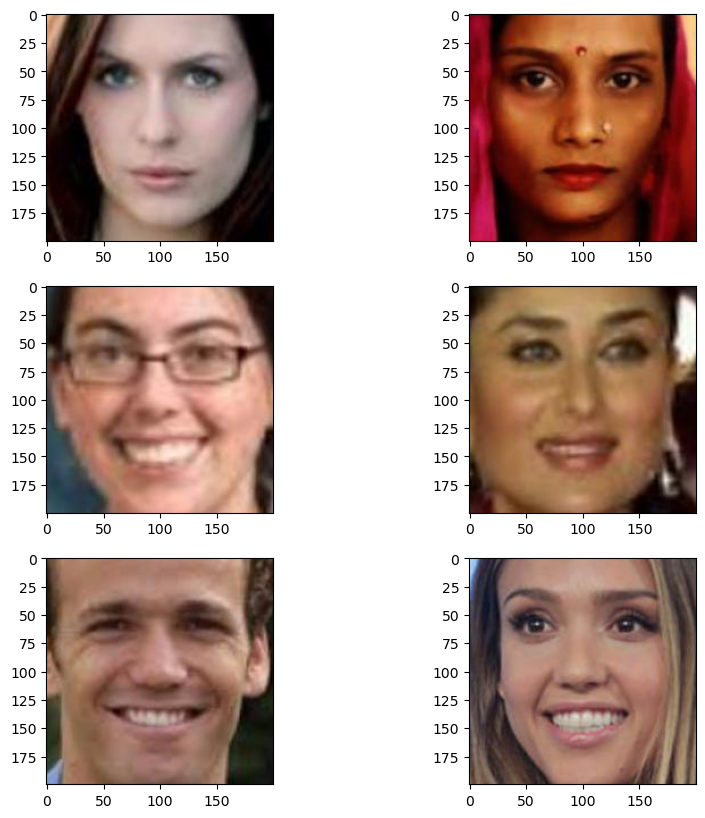

In [3]:
#Affichage d'images 
number_of_images = 6 #Définir le nombre x d'images à afficher 
plt.figure(figsize=(10,10))
age_folder = image_path + '033'
images = os.listdir(age_folder)[:number_of_images] # Selectionner aléatoirement x images
for i in range(number_of_images):
    file = mpimg.imread(age_folder +'/'+ images[i])
    plt.subplot(int(number_of_images/2),2,i+1)
    plt.imshow(file)



## Créattion de X et Y labels

In [4]:
X = []
Y = []
width = 100
height = 100 # resize to 100x100 to solve the RAM issue in Kaggle notebooks

for folder_name,_,filenames in os.walk(image_path):
    if folder_name !="face_age" and '.DS_Store' not in filenames :
        for file in filenames:
            file_path = folder_name +"/"+ file
            image = Image.open(file_path)
            image = image.convert('RGB')
            image = image.resize((width, height))
            X.append(np.array(image))
            Y.append(int(folder_name[-3:]))
    else:
        pass


In [5]:
# Normalise input data to range [0,1]
X = np.array(X)
X = X.astype('float32')
X /= 255.0
# confirm the normalization
print('Min: %.3f, Max: %.3f' % (X.min(), X.max()))

Y = np.array(Y)

Min: 0.000, Max: 1.000


## Train-Test split

In [6]:
# Train and testing split (70/30)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3,random_state=42,shuffle=True, stratify=Y)                                                                               


Age = 4


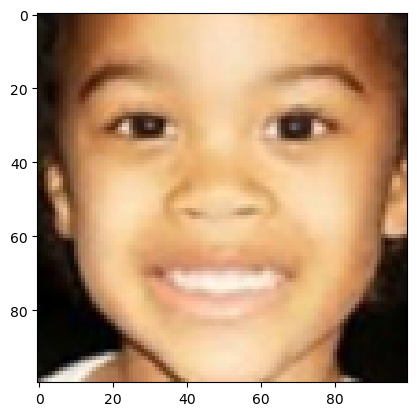

In [7]:
#Afficher une image au hasard du jeu de données (prendre le nombre qu'on veut du fait de random state)

print('Age =',Y_train[2])
plt.imshow(X_train[2])
plt.show()


# Générateur de données


In [28]:
train_datagen = ImageDataGenerator(
    shear_range = 0.2, # random application of shearing
    zoom_range = 0.2,
    horizontal_flip = True) # randomly flipping half of the images horizontally

test_datagen = ImageDataGenerator()

In [29]:
train_dataset = train_datagen.flow(X_train,Y_train,
                         batch_size = 128)


test_dataset = test_datagen.flow(X_test, Y_test, batch_size = 128) 





# Callbacks

In [30]:
from tensorflow.keras.callbacks import Callback
from timeit import default_timer as timer

class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

In [31]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

early_stopping = EarlyStopping(
                                patience=5, # Attendre 5 epochs avant application
                                min_delta = 0.01, # si au bout de 5 epochs la fonction de perte ne varie pas de 1%, 
    # que ce soit à la hausse ou à la baisse, on arrête
                                verbose=1, # Afficher à quel epoch on s'arrête
                                mode = 'min',
                                monitor='val_loss')

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=3, #si val_loss stagne sur 3 epochs consécutives selon la valeur min_delta
                                    min_delta= 0.01,
                                    factor=0.1,  # On réduit le learning rate d'un facteur 0.1
                                    cooldown = 4, # On attend 4 epochs avant de réitérer 
                                    verbose=1)

time_callback = TimingCallback()

        


## Entraînement du modèle

In [32]:
#Instanciation du modèle 
model = Sequential()

model.add(Conv2D(filters=32,kernel_size=(3,3),activation="relu",
                padding="valid",
                kernel_regularizer=regularizers.l2(0.00001),
                input_shape=(100, 100, 3)))

model.add(MaxPooling2D(pool_size=2, strides=2, padding='valid'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1,activation="linear")) 
    




In [33]:
#Compilation du modèle
model.compile(optimizer="adam",loss="mse",metrics=['mean_absolute_error'])



In [34]:
#Entrainement du modèle, utiliser le jeu de données augmenté, et préciser les callbacks 

batch_size = 128
epochs = 20 
model_history = model.fit_generator(
            train_dataset, # use augmented images for train 
            steps_per_epoch=X_train.shape[0] // batch_size,
            validation_data = test_dataset, # use augmented images for test
            epochs = epochs,
            callbacks = [
                         reduce_learning_rate,
                         early_stopping,
                         time_callback
                        ],
            verbose=True)


C:\Users\sarah\AppData\Local\Temp\ipykernel_4832\3718728934.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(


Epoch 1/20
106/106 [==============================] - 77s 712ms/step - loss: 614.2665 - mean_absolute_error: 20.3867 - val_loss: 444.0322 - val_mean_absolute_error: 17.6805 - lr: 0.0010
Epoch 2/20
106/106 [==============================] - 64s 598ms/step - loss: 401.9622 - mean_absolute_error: 16.1825 - val_loss: 359.8166 - val_mean_absolute_error: 15.8255 - lr: 0.0010
Epoch 3/20
106/106 [==============================] - 55s 522ms/step - loss: 356.7779 - mean_absolute_error: 15.0376 - val_loss: 305.0543 - val_mean_absolute_error: 13.9346 - lr: 0.0010
Epoch 4/20
106/106 [==============================] - 54s 509ms/step - loss: 326.7608 - mean_absolute_error: 14.3088 - val_loss: 301.3098 - val_mean_absolute_error: 14.1385 - lr: 0.0010
Epoch 5/20
106/106 [==============================] - 54s 508ms/step - loss: 314.7440 - mean_absolute_error: 13.9898 - val_loss: 306.6002 - val_mean_absolute_error: 13.2341 - lr: 0.0010
Epoch 6/20
106/106 [==============================] - 54s 512ms/step -

#  Performances du modèle

In [35]:
train_loss = model_history.history["loss"]
val_loss = model_history.history["val_loss"]
train_acc = model_history.history["mean_absolute_error"]
val_acc = model_history.history["val_mean_absolute_error"]


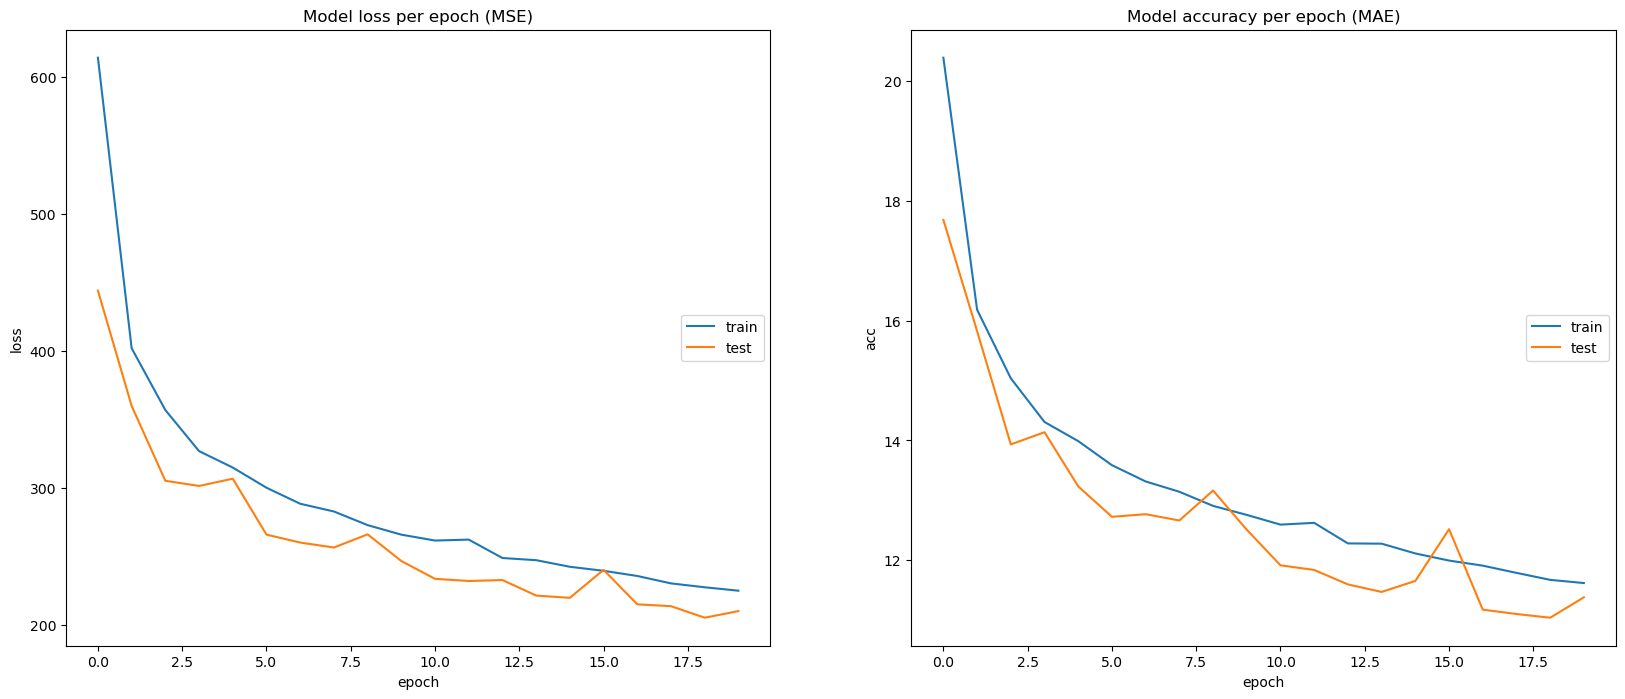

In [36]:
plt.figure(figsize = (20, 8))

plt.subplot(121)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model loss per epoch (MSE)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model accuracy per epoch (MAE)')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.show()
